In [4]:
import numpy as np
from matplotlib import pyplot as plt
from jax import numpy as jnp
import equinox as eqx
import quantax as qtx
from quantax.symmetry import Identity, ParticleConserve, Trans2D, C4v
from IPython.display import clear_output
%config InlineBackend.figure_format = 'svg'

qtx.set_default_dtype(jnp.float64)
L = 4

#4 x 4 square lattice 1/8 doping
lattice = qtx.sites.Square(L, is_fermion=True)
N = lattice.nsites
Nparticle = 10
sublattice = (4,4)
layers = 4 
Nhid = 4



/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sites/sites.py:29: UserWarning: A second 'sites' is defined.
  warn("A second 'sites' is defined.")


In [5]:
hamiltonian = qtx.operator.Hubbard(U=8)

#Mean field wavefunction is pfaffian with a 2x2 unit cell
mf = qtx.model.Pfaffian(Nparticle=Nparticle, dtype=jnp.float64, sublattice=sublattice)

state = qtx.state.Variational(mf,symm=ParticleConserve([Nparticle//2,Nparticle//2]),max_parallel=32768)

sampler = qtx.sampler.NeighborExchange(state,1000)
tdvp = qtx.optimizer.TDVP(state,hamiltonian,solver=qtx.optimizer.auto_pinv_eig(rtol=1e-6))





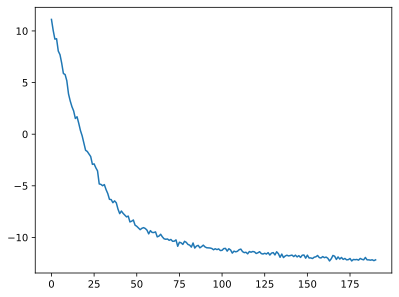

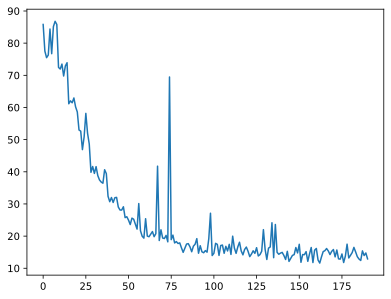

In [6]:
energy_data = qtx.utils.DataTracer()
variance_data = qtx.utils.DataTracer()
for i in range(200):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step*0.01)
    energy_data.append(tdvp.energy)
    variance_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        variance_data.plot()
        plt.show()

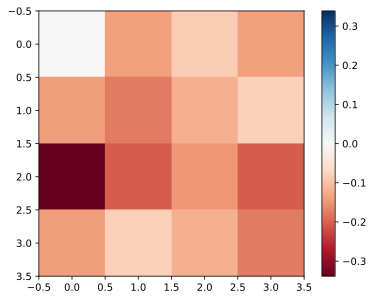

In [7]:
#look at <s^z_i s^z_j> and <n_i n_j> for mean field

samps = samples.spins
spins = samps[:,:N] - samps[:,N:]
spins = spins.reshape(-1,L,L)
charge = samps[:,:N] + samps[:,N:]
charge = charge.reshape(-1,L,L)

charge_charge = jnp.zeros([L,L])
spin_spin = jnp.zeros([L,L])
for i in range(L):
    for j in range(L):
        corr_spin = jnp.mean(spins*jnp.roll(spins,(i,j),axis=(-2,-1)))
        corr_charge = jnp.mean(charge*jnp.roll(charge,(i,j),axis=(-2,-1)))

        spin_spin = spin_spin.at[i,j].set(corr_spin)       
        charge_charge = charge_charge.at[i,j].set(corr_charge)       

spin_spin = spin_spin.at[0,0].set(0)
charge_charge = charge_charge.at[0,0].set(0)

maxval = jnp.amax(jnp.abs(spin_spin))
plt.imshow(spin_spin, cmap='RdBu', vmin=-1*maxval,vmax=maxval)
plt.colorbar()



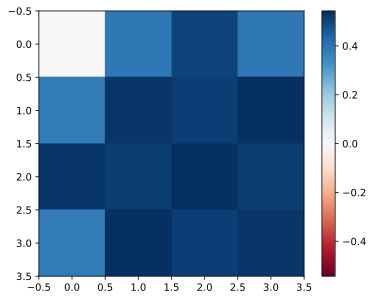

In [8]:
maxval = jnp.amax(jnp.abs(charge_charge))
plt.imshow(charge_charge, cmap='RdBu', vmin=-1*maxval,vmax=maxval)
plt.colorbar()


In [9]:
#CNN network is used to output the configuration dependent hidden-visible and hidden-hidden pairings
net = qtx.model.ResSum(layers,4*Nhid,3,final_activation=lambda x: x, trans_symm=Identity(), dtype=jnp.float64)
model = qtx.model.HiddenPfaffian(Nvisible=Nparticle, pairing_net = net, dtype=jnp.float64, sublattice=sublattice, trans_symm = Trans2D())

model = eqx.tree_at(lambda tree: tree.layers[-1].F, model, mf.F)

In [10]:
state = qtx.state.Variational(model,symm=ParticleConserve([Nparticle//2,Nparticle//2]),max_parallel=32768)
sampler = qtx.sampler.NeighborExchange(state,1000)
tdvp = qtx.optimizer.TDVP(state,hamiltonian,solver=qtx.optimizer.auto_pinv_eig(rtol=1e-6))


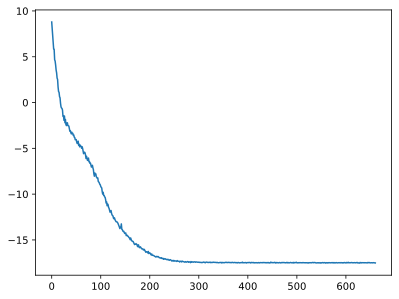

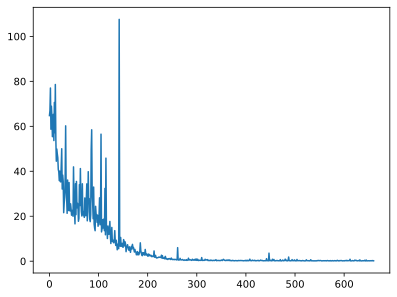

0.008975744247436523


/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:38: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:245: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/sampler/metropolis.py:333: SyntaxWarning: invalid escape sequence '\p'
  """
/mnt/home/croth/miniconda3/lib/python3.12/site-packages/quantax/state/variational.py:530: SyntaxWarning: invalid escape sequence '\l'
  """


KeyboardInterrupt: 

In [11]:
energy_data = qtx.utils.DataTracer()
variance_data = qtx.utils.DataTracer()
for i in range(500):
    samples = sampler.sweep()
    step = tdvp.get_step(samples)
    state.update(step*0.01)
    energy_data.append(tdvp.energy)
    variance_data.append(tdvp.VarE)

    if i % 10 == 0:
        clear_output()
        energy_data.plot()
        plt.show()
        variance_data.plot()
        plt.show()